In [1]:
import numpy as np
import numpy.random as random
import math
tgNum = 15
rdNum = 3
time_samples = 100
radarPositions = []
radarPositions.append([50,50])
radarPositions.append([250,200])
radarPositions.append([80,20])
rdNum = len(radarPositions)
x_true = np.zeros((time_samples,tgNum))
y_true = np.zeros((time_samples,tgNum))
x_report = np.zeros((time_samples,tgNum,rdNum))
y_report = np.zeros((time_samples,tgNum,rdNum))
speed = np.zeros(tgNum)
course = np.zeros(tgNum)

for tgID in range (0,tgNum):
    #khởi tại giá trị tại mốc 0 thời gian
    x_true[0][tgID]= random.random()*15+100 #giá trị phân bố đều từ 100 đến 115km
    y_true[0][tgID]= random.random()*15+100 #giá trị phân bố đều từ 100 đến 115km
    speed[tgID] = 0.05+random.random()*0.1#speed from 18 to 54km/h
    course[tgID] = random.random()*3.1415926535*2# từ 0 đến 2pi
    #cập nhật tọa độ thực của mục tiêu dựa trên tốc đọ và hướng di chuyển
    for timeIndex in range(1,time_samples):
        
        dx = speed[tgID]*math.sin(course[tgID])  
        dy = speed[tgID]*math.cos(course[tgID]) 
        x_true[timeIndex][tgID] = dx + x_true[timeIndex-1][tgID]
        y_true[timeIndex][tgID] = dy + y_true[timeIndex-1][tgID]
    #cập nhật tọa độ đo được của mục tiêu dựa trên tọa độ cự ly phương vị từ các đài và sai số đo 
    for timeIndex in range(0,time_samples):
        for rdID in range(0,rdNum):
            dx = x_true[timeIndex][tgID]-radarPositions[rdID][0]
            dy = y_true[timeIndex][tgID]-radarPositions[rdID][1]
            r_target = math.sqrt(dx*dx+dy*dy) + np.random.normal(0, 0.005, 1)[0]#sai số đo cự ly sigma = 0.005km
            azi_target = math.atan(dx/dy) + np.random.normal(0, 0.4/57.3, 1)[0]#sai số đo phương vị sigma = 0.4 độ
            if (dy<0):
                azi_target = azi_target+3.1415926535
            x_report[timeIndex][tgID][rdID] = radarPositions[rdID][0]+r_target*math.sin(azi_target)
            y_report[timeIndex][tgID][rdID] = radarPositions[rdID][1]+r_target*math.cos(azi_target)
            
        
    

In [2]:
speed

array([0.06762781, 0.05104508, 0.08709602, 0.09261497, 0.13451247])

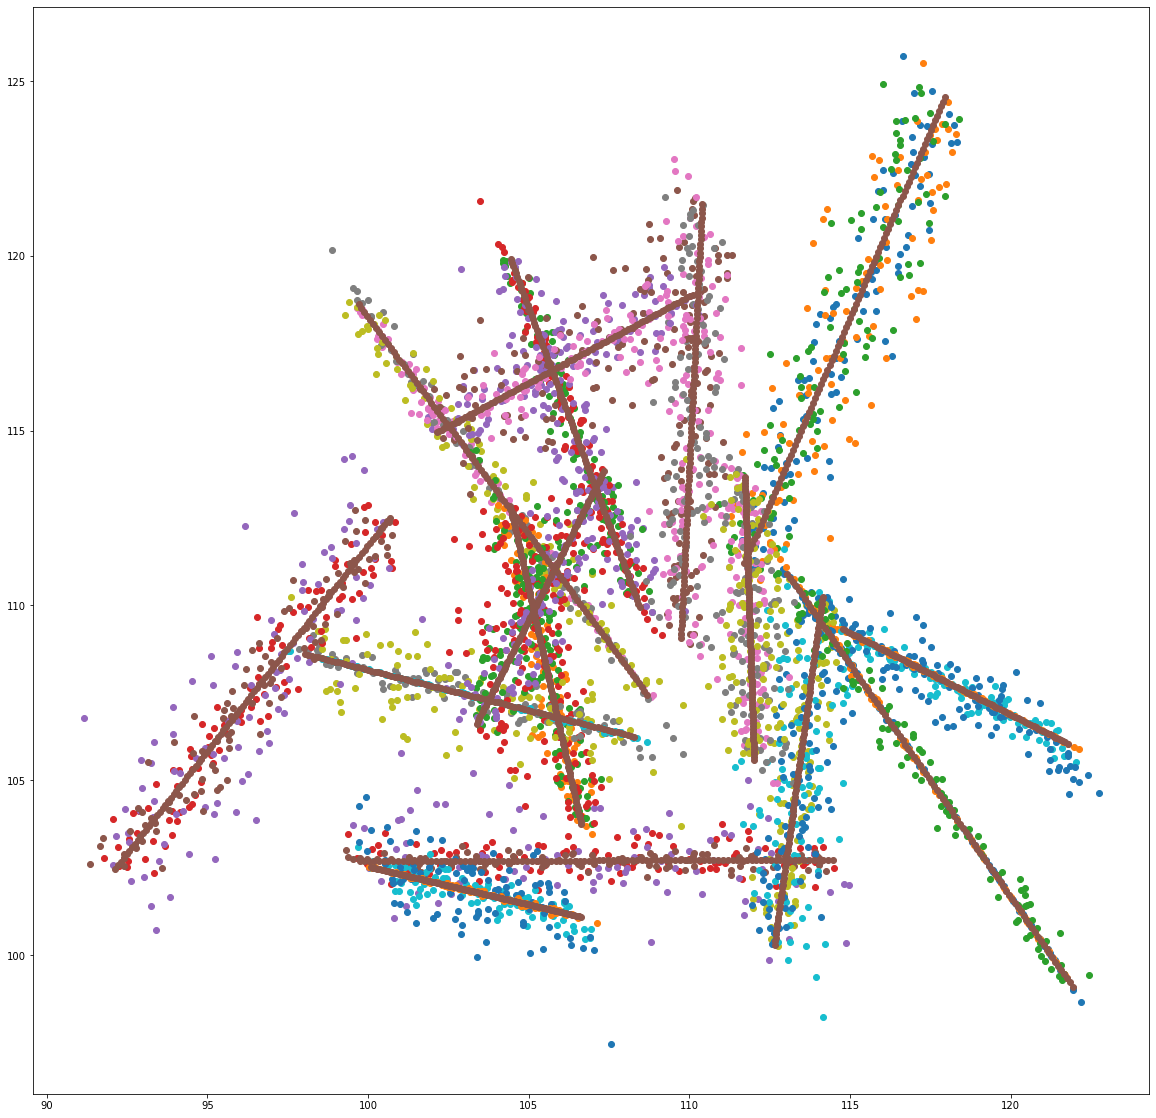

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#vẽ quỹ đạo 1 mục tiêu trên các đài khác nhau
figure(figsize=(20,20))
for targetIndex in range(0,tgNum):
    for radarIndex in range(0,rdNum):
        plt.scatter(x_report[:, targetIndex,radarIndex], y_report[:, targetIndex,radarIndex])
# for targetIndex in range(0,tgNum):
plt.scatter(x_true[:, :], y_true[:, :])
plt.show()

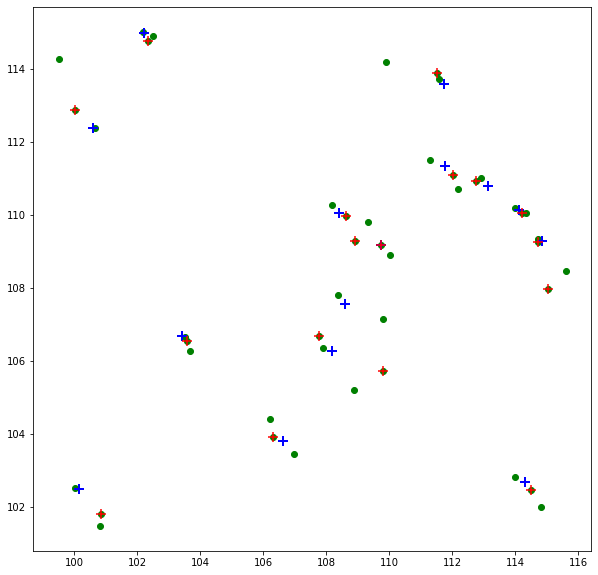

In [5]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from copy import deepcopy
figure(figsize=(10,10))
#lấy dữ liệu quỹ đạo tại 1 thời điểm t = timeIndex
timeIndex = 1
#tạo mảng rỗng để chứa dữ liệu
data = np.zeros((tgNum*rdNum,2))
#ghi tọa độ của các điểm dấu vào mảng data (số lượng điểm dấu =  tgNum*rdNum)
for tgID in range(0,tgNum):
    for radarIndex in range(0,rdNum):
        data[tgID*rdNum+radarIndex,0] = x_report[timeIndex,tgID,radarIndex]
        data[tgID*rdNum+radarIndex,1] = y_report[timeIndex,tgID,radarIndex]
        plt.scatter(x_report[timeIndex, tgID,radarIndex], y_report[timeIndex, tgID,radarIndex],c='g')
#vẽ các mục tiêu dạng dấu cộng màu xanh
for tgID in range(0,tgNum):
    plt.scatter(x_true[timeIndex, :], y_true[timeIndex, :],c='b',marker='+', s=100)
#tạo mảng chứa các tâm lớp, khi khởi tạo, mảng tâm lớp chính là mảng tất cả các điểm dấu
cluster_centers = data 
#định nghĩa hàm khoảng cách giữa 2 điểm dấu
def distance_D(A,B):
    d1 = abs(A[0]-B[0])
    d2 = abs(A[1]-B[1])
    return math.sqrt(d1*d1+d2*d2)
#đặt kích thước cửa sóng phương sai = 0.3km
CONST = 1/0.3

#bắt đầu chạy thuật toán
while len(cluster_centers)>1:
    plotNum = len(cluster_centers)
    #tạo ma trận liên thuộc có kích thước = plotNum x plotNum
    cluster_P = np.zeros(([plotNum,plotNum]))
    #
    max_element_value = 0
    max_element_index = 0
    # tính giá trị hàm mật độ và tìm kiếm điểm có giá trị tối đa
    for plotID in range(0,plotNum):
        for k in range(0,plotNum):
            if k==plotID:
                #độ liên thuộc của 1 điểm dấu đến chính nó = 0
                cluster_P[plotID,k] = 0
            else:
                #độ liên thuộc của 2 điểm dấu được xác định bới công thức
                cluster_P[plotID,k] = math.exp(-CONST*distance_D(cluster_centers[plotID],cluster_centers[k]) )
        #giá trị mật độ được tính bằng tổng của các giá trị liên thuộc từ 1 điểm đến tất cả các điểm khác
        value = 0
        for k in range(0,plotNum):
            value+=(cluster_P[plotID,k])
        #tìm và lưu điểm giá trị mật độ tối đa của các tâm lớp
        if value>max_element_value:
            max_element_value = value
            max_element_index = plotID
    #vẽ điểm giá trị mật độ tối đa (chính là tâm lớp mới tìm được)
    plt.scatter(cluster_centers[max_element_index,0],cluster_centers[max_element_index,1],c='r',marker='+', s=100)
    #tìm các điểm liên thuộc cùng class với điểm giá trị mật độ tối đa và loại bỏ khỏi mảng dữ liệu
    remove = 1
    for plotID in range(0,plotNum):
        nearest_point_index = 0
        nearest_point_value = 0
        for k in range(0,plotNum):
            if nearest_point_value< cluster_P[plotID,k]:
                nearest_point_value = cluster_P[plotID,k]
                nearest_point_index = k
        if(nearest_point_index==max_element_index):
            cluster_centers[plotID] = [0,0]
            remove = remove+1
    cluster_centers[max_element_index] = [0,0]
    cluster_centers = np.array([ elem for elem in cluster_centers if elem[0] != 0 and elem[1] != 0])
#vẽ các điểm còn sót lại trong mảng cluster_centers sau khi chạy thuật toán
for plotID in range(0,len(cluster_centers)):
    plt.scatter(cluster_centers[plotID,0],cluster_centers[plotID,1], c='b', s=30)

 


In [133]:
data

array([[101.96579779, 104.52427082],
       [103.41762455, 102.43142544],
       [101.74199289, 104.45585503],
       [101.53290416, 102.19472554],
       [100.44589082, 103.70407289],
       [100.88504348, 102.55528373],
       [103.64492332, 100.52662356],
       [103.09468047, 101.47154214],
       [103.63527546, 100.28312707],
       [104.36691976, 101.66934159],
       [105.44992158, 100.10926378],
       [103.54971944, 101.89866856],
       [103.44085155, 105.51557086],
       [103.41714005, 105.22871112],
       [102.44855582, 106.10672638],
       [108.70386934, 104.21130979],
       [108.62696144, 104.41849938],
       [108.55411035, 104.06859376]])

<Figure size 1440x1440 with 0 Axes>

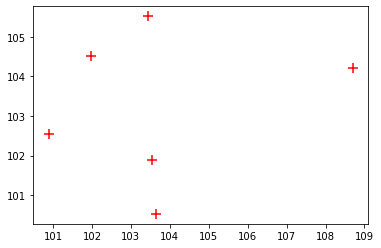

In [134]:

    # for plotID in range(0,plotNum):

In [130]:
data


array([[101.96579779, 104.52427082],
       [103.41762455, 102.43142544],
       [101.74199289, 104.45585503],
       [101.53290416, 102.19472554],
       [100.44589082, 103.70407289],
       [100.88504348, 102.55528373],
       [103.64492332, 100.52662356],
       [103.09468047, 101.47154214],
       [103.63527546, 100.28312707],
       [104.36691976, 101.66934159],
       [105.44992158, 100.10926378],
       [103.54971944, 101.89866856],
       [103.44085155, 105.51557086],
       [103.41714005, 105.22871112],
       [102.44855582, 106.10672638],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [96]:
cluster_centers

array([[101.96579779, 104.52427082],
       [103.41762455, 102.43142544],
       [101.74199289, 104.45585503],
       [101.53290416, 102.19472554],
       [100.44589082, 103.70407289],
       [100.88504348, 102.55528373],
       [103.64492332, 100.52662356],
       [103.09468047, 101.47154214],
       [103.63527546, 100.28312707],
       [104.36691976, 101.66934159],
       [105.44992158, 100.10926378],
       [103.54971944, 101.89866856],
       [103.44085155, 105.51557086],
       [103.41714005, 105.22871112],
       [102.44855582, 106.10672638],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [23]:
cluster_centers = np.zeros(([number_of_targets*number_of_radars,2]))
cluster_P = np.zeros(([number_of_targets*number_of_radars]))
def distance_D(A,B):
    d1 = abs(A[0]-B[0])
    d2 = abs(A[1]-B[1])
    return math.sqrt(d1*d1+d2*d2)
figure(figsize=(15,15))
CONST = 3
import matplotlib.cm as cm
for i in range(0,number_of_targets):
    for j in range(0,number_of_radars):
        cluster_centers[i*20+j] = (100+i/4,100+j/4)
        
        cluster_P[i*20+j] = 0
        for k in range(0,number_of_targets*number_of_radars):
            cluster_P[i*20+j] += math.exp(-CONST*distance_D(cluster_centers[i*20+j],data[k]) )
        colo=(cluster_P[i*20+j])/1.5
        if(colo<=0):
            colo=0
        if(colo>1):
            colo=1
        plt.scatter(cluster_centers[i*20+j,0],cluster_centers[i*20+j,1],c=[(colo,1-colo,0)],s=60)

array([5.37689638e-12, 1.17389270e-11, 2.52538434e-11, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [21]:
for i in range(0,20):
    for j in range(0,20):
        

array([[[100. , 100. ],
        [100. , 100.2],
        [100. , 100.4],
        ...,
        [100. , 109.4],
        [100. , 109.6],
        [100. , 109.8]],

       [[100.2, 100. ],
        [100.2, 100.2],
        [100.2, 100.4],
        ...,
        [100.2, 109.4],
        [100.2, 109.6],
        [100.2, 109.8]],

       [[100.4, 100. ],
        [100.4, 100.2],
        [100.4, 100.4],
        ...,
        [100.4, 109.4],
        [100.4, 109.6],
        [100.4, 109.8]],

       ...,

       [[109.4, 100. ],
        [109.4, 100.2],
        [109.4, 100.4],
        ...,
        [109.4, 109.4],
        [109.4, 109.6],
        [109.4, 109.8]],

       [[109.6, 100. ],
        [109.6, 100.2],
        [109.6, 100.4],
        ...,
        [109.6, 109.4],
        [109.6, 109.6],
        [109.6, 109.8]],

       [[109.8, 100. ],
        [109.8, 100.2],
        [109.8, 100.4],
        ...,
        [109.8, 109.4],
        [109.8, 109.6],
        [109.8, 109.8]]])

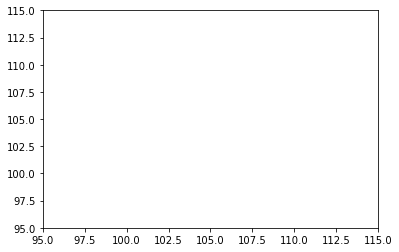

In [5]:
#kmean clustering
import math
axes = plt.gca()
axes.set_xlim([95,115])
axes.set_ylim([95,115])
clusters=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for i in range(0,1):
    clusterData = data[clusters == i]
    plt.scatter(clusterData[:,0], clusterData[:,1], s=7)
plt.show()

In [97]:
clusterData

array([], shape=(0, 15, 2), dtype=float64)

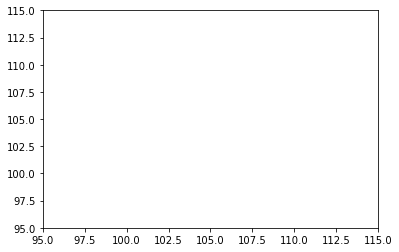

number of classes: 1
Iterations: 3


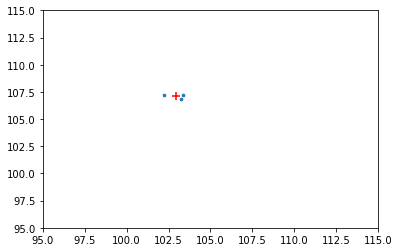

number of classes: 2
Iterations: 3


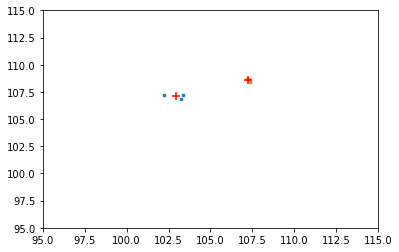

number of classes: 3
Iterations: 3


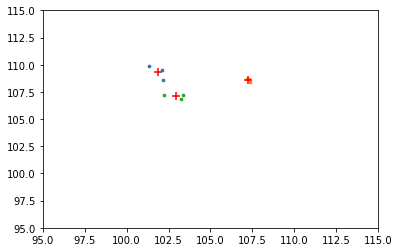

number of classes: 4
Iterations: 3


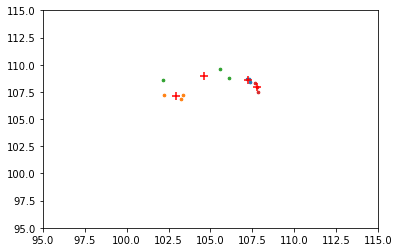

number of classes: 5
Iterations: 2


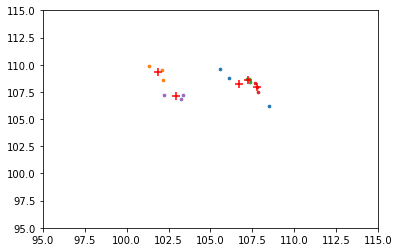

number of classes: 6
Iterations: 3


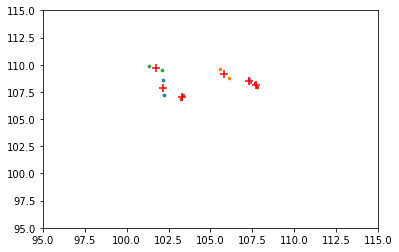

number of classes: 7
Iterations: 3


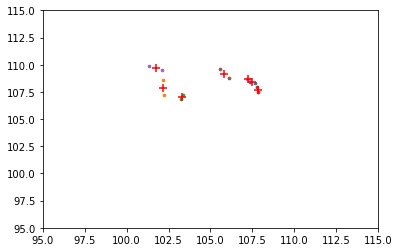

number of classes: 8
Iterations: 2


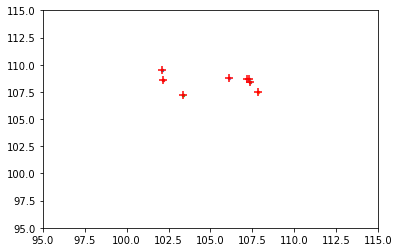

In [92]:
#kmean clustering
import math
axes = plt.gca()
axes.set_xlim([95,115])
axes.set_ylim([95,115])
clusters=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for i in range(0,5):
    clusterData = data[clusters == i]
    plt.scatter(clusterData[:,0], data[:,1], s=7)
plt.show()
max_distance = 100
# Number of clusters
for k in range(1,9): #number_of_targets
    print("number of classes:",k)
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(k,2)*std + mean
    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers
    clusters = np.zeros(n)
    distances = np.zeros((n,k))
    max_samples_per_cluster = number_of_radars
    error = 1
    numIter = 0
    max_plot_perTarget = math.floor(n/k)
    if(max_plot_perTarget<1):
        max_plot_perTarget=1
    if(max_plot_perTarget>number_of_radars):
        max_plot_perTarget=number_of_radars    
    while error>0:
        numIter+=1
        
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1)
            #eanDistances = np.mean(distances[:,i])
            #tances[:,i] = distances[:,i] /meanDistances
        sortedDistance = np.zeros((n,k))
        clusterMap = np.zeros((n,k))
        clusters = np.zeros(n)-np.ones(n)
        switches=1
        while switches>0:
            switches=0
            for i in range(k):
                sortedDistance[:,i] = np.sort (distances[:,i])
                for j in range(n):
                    clusterMap[j,i] = 1 if distances[j,i] <= sortedDistance [max_plot_perTarget-1,i] else 0
    #         print("clusterMap before:",clusterMap)
            for j in range(n):
                for i in range(k):
                    if(clusterMap[j,i]>0):
                        for i_ in range(k):
                            if (clusterMap[j,i_]>0)&(i!=i_):
                                if(distances[j,i]>distances[j,i_]):
                                    clusterMap[j,i] = 0
                                    distances[j,i] = 100
                                    switches+=1
#             print("switches:",switches)
    #     clusters = np.argmax(clusterMap, axis = 1) 
        clusters = np.zeros(n)-np.ones(n)
        for i in range(k):
            for j in range(n):
                if clusterMap[j,i]==1:
    #                 if distances[j,i]<max_distance:
                    clusters[j] = i
        centers_old = deepcopy(centers_new)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            clusterData = data[clusters == i]
            centers_new[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers_old) 
    print("Iterations:",numIter)
    #lọc nhiễu dựa trên max_distance
    for j in range(n):
        if(clusters[j]>=0):
            if(distances[j,math.floor(clusters[j])]>max_distance):
                clusters[j]=-1
    #tính lại centers
    for i in range(k):
            centers_new[i] = np.mean(data[clusters == i], axis=0)
    # Plot the data and the centers generated as random
    for i in range(k):
        clusterData = data[clusters == i]
        plt.scatter(clusterData[:,0], clusterData[:,1], s=7)
        plt.scatter(centers_new[i,0], centers_new[i,1], c='r',marker='+', s=50)
    axes = plt.gca()
    axes.set_xlim([95,115])
    axes.set_ylim([95,115])
    plt.show()
    #loc nhieu

In [48]:
for i in range(k):
        distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
        
sortedDistance = np.zeros((n,k))
clusterMap = np.zeros((n,k))
clusters = np.zeros(n)-np.ones(n)
switches=1
while switches>0:
    switches=0
    for i in range(k):
        sortedDistance[:,i] = np.sort (distances[:,i])
        for j in range(n):
            clusterMap[j,i] = 1 if distances[j,i] < sortedDistance [max_plot_perTarget,i] else 0
#         print("clusterMap before:",clusterMap)
    for j in range(n):
        for i in range(k):
            if(clusterMap[j,i]>0):
                for i_ in range(k):
                    if (clusterMap[j,i_]>0)&(i!=i_):
                        if(distances[j,i]>distances[j,i_]):
                            clusterMap[j,i] = 0
                            distances[j,i] = max_distance
                            switches+=1
    print("switches:",switches)
clusters = np.zeros(n)-np.ones(n)
for i in range(k):
    for j in range(n):
        if clusterMap[j,i]==1:
            if distances[j,i]<max_distance:
                clusters[j] = i
centers_old = deepcopy(centers_new)
# Calculate mean for every cluster and update the center
for i in range(k):
    clusterData = data[clusters == i]
    centers_new[i] = np.mean(data[clusters == i], axis=0)
error = np.linalg.norm(centers_new - centers_old)  

switches: 7
switches: 6
switches: 6
switches: 3
switches: 1
switches: 0


In [60]:
clusterData

array([[107.35025642, 108.42232199],
       [107.16498283, 108.6655908 ],
       [107.29840259, 108.66058896]])

In [45]:
clusterMap

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
plt.scatter(x_report[timeIndex, :,:], y_report[timeIndex, :,:])
plt.show()